# Dataset processing and augmentation

The `galaxy_datasets` framework provides an advanced capabilities for model training including multi-label training. This notebook is my attempt to simplify the dataset structure for further experiments. 

## Step 0: Environment dependencies setup

In [ ]:
%pip install --upgrade pip

In [ ]:
!pip3 install galaxy-datasets # GZ2 dataset
!pip3 install matplotlib
!pip3 install scikit-learn
!pip3 install pandas

## Step 1: Import dependencies

In [ ]:
import os
import shutil
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from galaxy_datasets.pytorch import GZ2 # galaxy-datasets

## Step 2: Load GZ2 dataset

In [ ]:
os.makedirs('gz2', exist_ok=True)

train_gz2 = GZ2(root='gz2', train=True, download=True)
test_gz2  = GZ2(root='gz2', train=False, download=True)

train_catalog = train_gz2.catalog.copy()
test_catalog  = test_gz2.catalog.copy()

train_catalog = train_catalog[['filename', 'summary']]
test_catalog  = test_catalog[['filename', 'summary']]

# Replace missing summaries
train_catalog['summary'] = train_catalog['summary'].fillna('irregular')
test_catalog['summary']  = test_catalog['summary'].fillna('irregular')

# Rename "summary" into "label"
train_catalog.rename(columns={'summary': 'label'}, inplace=True)
test_catalog.rename(columns={'summary': 'label'}, inplace=True)

print("train catalog length:", len(train_catalog))
print("test catalog length: ", len(test_catalog))


train catalog length: 167434
test catalog length:  41859


In [67]:
train_catalog['orig_img_path'] = train_catalog['filename'].apply(
    lambda x: os.path.join('gz2', 'images', x[:6], x)
)
test_catalog['orig_img_path'] = test_catalog['filename'].apply(
    lambda x: os.path.join('gz2', 'images', x[:6], x)
)

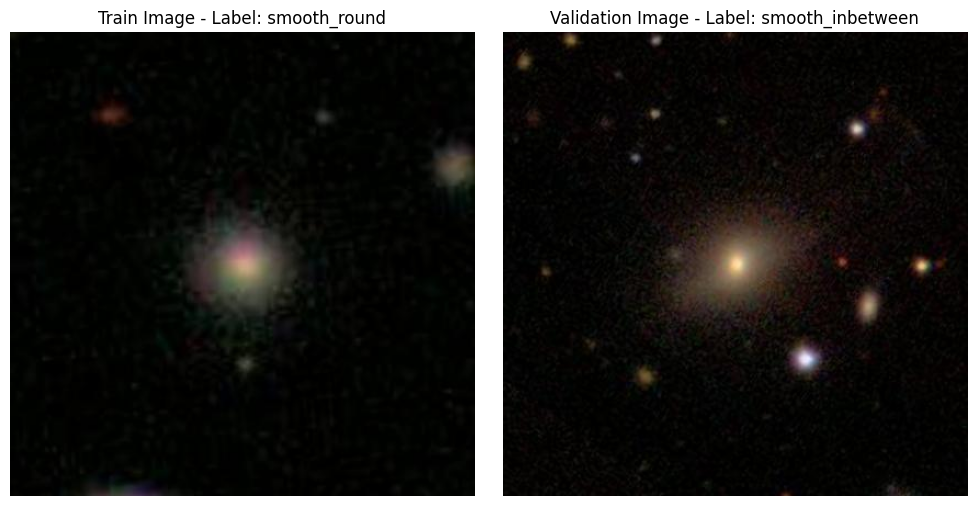

In [69]:
# Get file paths and labels from the DataFrames
t_image_path, t_label = train_catalog['orig_img_path'][0], train_catalog['label'][0]
v_image_path, v_label = test_catalog['orig_img_path'][0], test_catalog['label'][0]

# Load the images using PIL
t_image = Image.open(t_image_path)
v_image = Image.open(v_image_path)

# Plot the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(t_image)
axes[0].set_title(f"Train Image - Label: {t_label}")
axes[0].axis('off')

axes[1].imshow(v_image)
axes[1].set_title(f"Validation Image - Label: {v_label}")
axes[1].axis('off')

plt.tight_layout()
plt.show()


## Step 4: Split the Train Catalog into Train / Val sets

In [70]:
df_train, df_val = train_test_split(
    train_catalog, test_size=0.25, random_state=42, shuffle=True
)

df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
test_catalog.reset_index(drop=True, inplace=True)

print(f"Train subset size: {len(df_train)}")
print(f"Val subset size:   {len(df_val)}")
print(f"Test set size:   {len(test_catalog)}")

Train subset size: 125575
Val subset size:   41859
Test set size:   41859


In [ ]:
def copy_and_update(df, target_dir):
    new_paths = []
    for i, row in df.iterrows():
        src_path = row['orig_img_path']
        filename = str(i) + '_' + target_dir + ".jpg"
        dst_path = os.path.join(target_dir, filename)
        try:
            shutil.copy2(src_path, dst_path)
        except Exception as e:
            print(f"Error copying {src_path} to {dst_path}: {e}")
        new_paths.append(dst_path)
    df['img_path'] = new_paths
    return df

In [74]:
os.makedirs('train', exist_ok=True)
os.makedirs('validation', exist_ok=True)
os.makedirs('test', exist_ok=True)

In [75]:
print("Copying train images ...")
df_train = copy_and_update(df_train, 'train')
print("Copying validation images ...")
df_val = copy_and_update(df_val, 'validation')
print("Copying test images ...")
df_test = copy_and_update(test_catalog, 'test')

Copying train images ...
Copying validation images ...
Copying test images ...


In [ ]:
print("Saving Parquet files ...")
df_train[['img_path', 'label']].to_parquet('train.parquet', index=False)
df_val[['img_path', 'label']].to_parquet('validation.parquet', index=False)
df_test[['img_path', 'label']].to_parquet('test.parquet', index=False)
print("Dataset preparation complete!")


Saving Parquet files ...
Dataset preparation complete!


In [86]:
df_train_new = df_train[['img_path', 'label']]
df_train_new

,img_path,label
0,train/0_train.jpg,smooth_inbetween
1,train/1_train.jpg,unbarred_spiral
2,train/2_train.jpg,smooth_round
3,train/3_train.jpg,unbarred_spiral
4,train/4_train.jpg,smooth_cigar
...,...,...
125570,train/125570_train.jpg,barred_spiral
125571,train/125571_train.jpg,unbarred_spiral
125572,train/125572_train.jpg,featured_without_bar_or_spiral
125573,train/125573_train.jpg,smooth_round
